# Analyze the HNN toy task

In [13]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-toy'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_field, circular_vector_field
from nn_models import MLP
from hnn import HNN
from utils import L2_loss

## Set some notebook constants

In [14]:
DPI = 120
FORMAT = 'png'
LINE_SEGMENTS = 10
ARROW_SCALE = 30
ARROW_WIDTH = 6e-3
LINE_WIDTH = 2
RK4 = ''

def get_args():
    return {'input_dim': 2,
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 1000,
         'field_type': 'solenoidal',
         'print_every': 200,
         'name': 'toy',
         'gridsize': 10,
         'input_noise': 0.5,
         'seed': 0,
         'save_dir': './{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Inspect the toy dataset

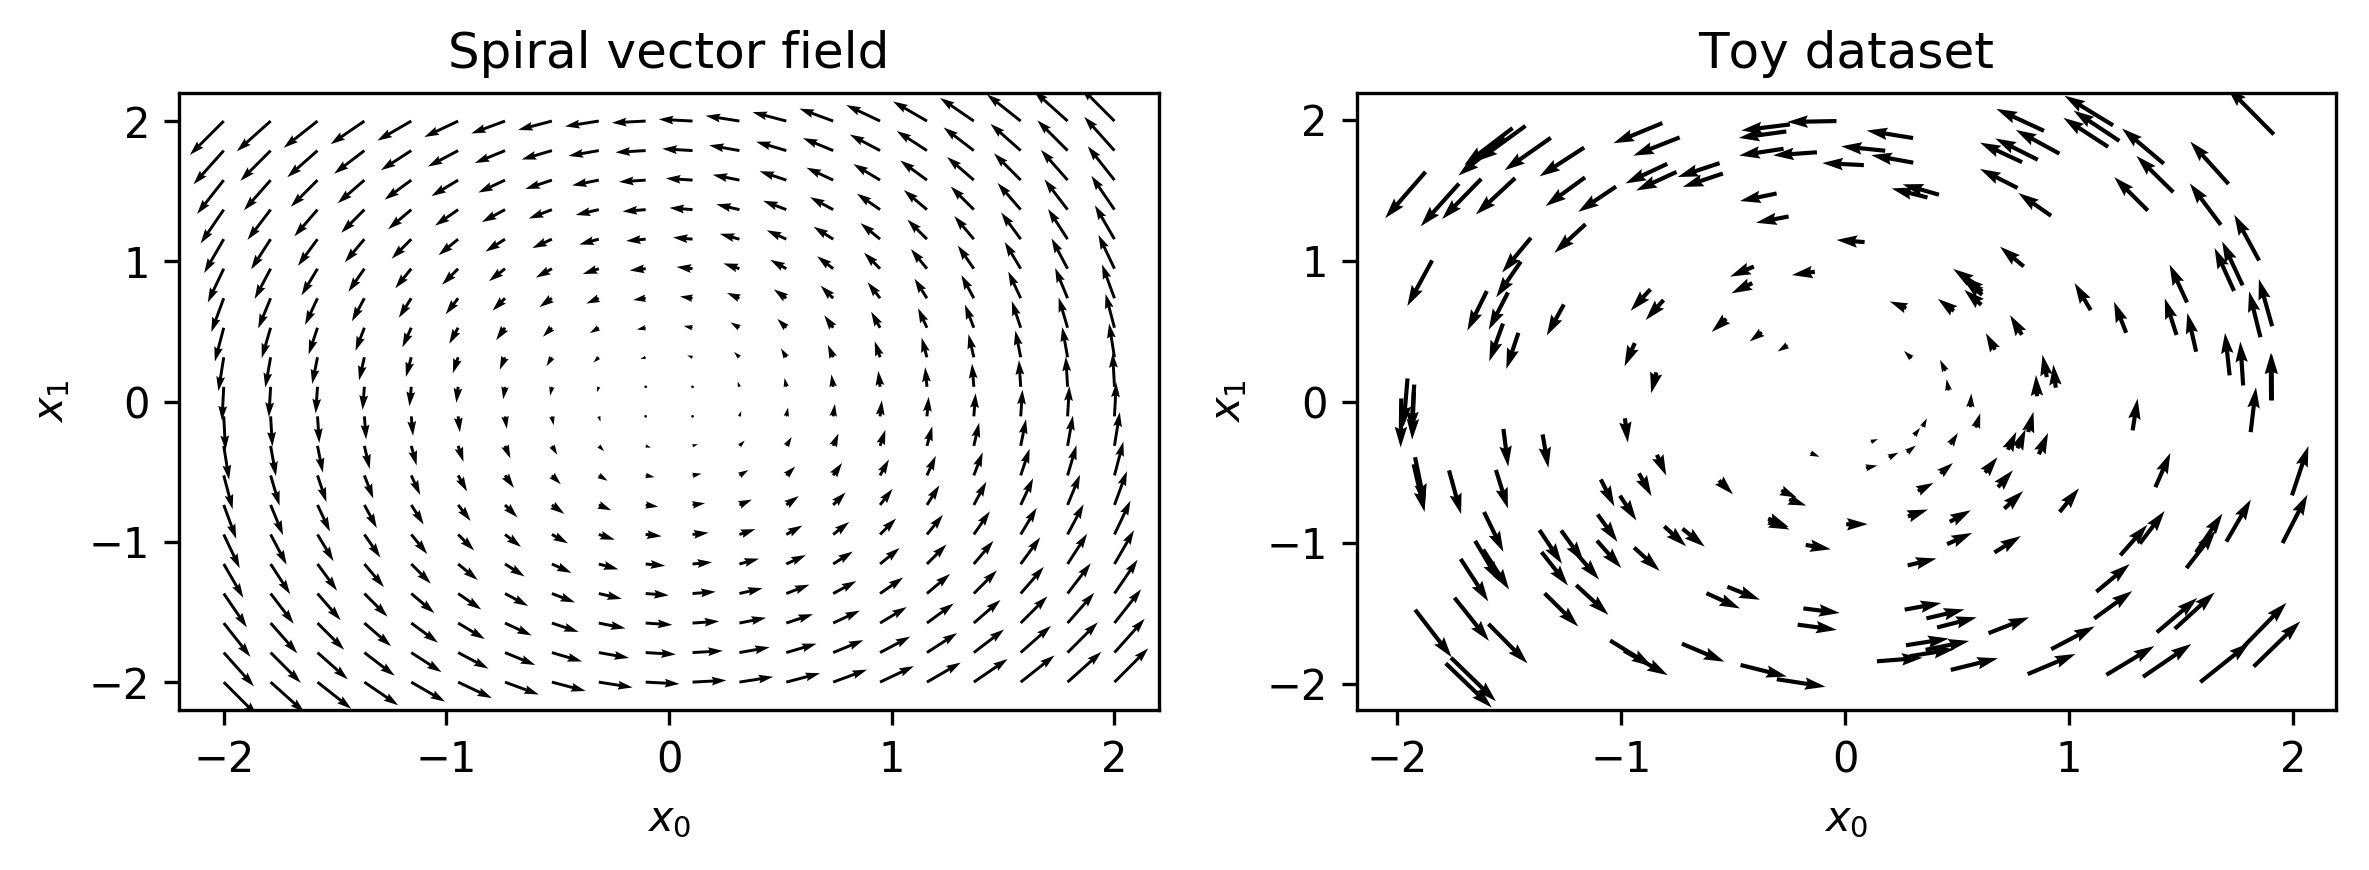

In [15]:
args = ObjectView(get_args())
np.random.seed(args.seed)
field, data = get_field(), get_dataset()

# plot config
fig = plt.figure(figsize=(8, 3), facecolor='white', dpi=DPI)

# plot spiral vector field
ax = fig.add_subplot(1, 2, 1, frameon=True)
ax.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1], cmap='gray_r' )
ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Spiral vector field")

# plot dataset
ax = fig.add_subplot(1, 2, 2, frameon=True)
ax.quiver(data['x'][:,0], data['x'][:,1], data['dx'][:,0], data['dx'][:,1], cmap='gray_r' )
ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Toy dataset")

plt.tight_layout() ; plt.show()
# fig.savefig(fig_dir + '/toy-task.png')

## Construct models

In [16]:
def get_model(args, baseline):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/toy{}-{}.tar".format(args.save_dir, RK4, model_name)
    model.load_state_dict(torch.load(path))
    return model

## Get vector fields

In [17]:
def get_vector_field(model, **kwargs):
    field = get_field(**kwargs)
    np_mesh_x = field['x']
    
    # run model
    mesh_x = torch.tensor( np_mesh_x, requires_grad=True, dtype=torch.float32)
    mesh_dx = model.time_derivative(mesh_x)
    return mesh_dx.data.numpy()

## Integrate along vector fields

In [18]:
def integrate_model(model, t_span, y0, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

## Run analysis

In [19]:
base_model = get_model(args, baseline=True)
hnn_model = get_model(args, baseline=False)

# get their vector fields
field = get_field(gridsize=args.gridsize)
data = get_dataset()
base_field = get_vector_field(base_model, gridsize=args.gridsize)
hnn_field = get_vector_field(hnn_model, gridsize=args.gridsize)

# integrate along those fields starting from point (1,0)
t_span = [0,30]
y0 = np.asarray([1.5, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 1000), 'rtol': 1e-12}
base_ivp = integrate_model(base_model, t_span, y0, **kwargs)
hnn_ivp = integrate_model(hnn_model, t_span, y0, **kwargs)

## Plot results

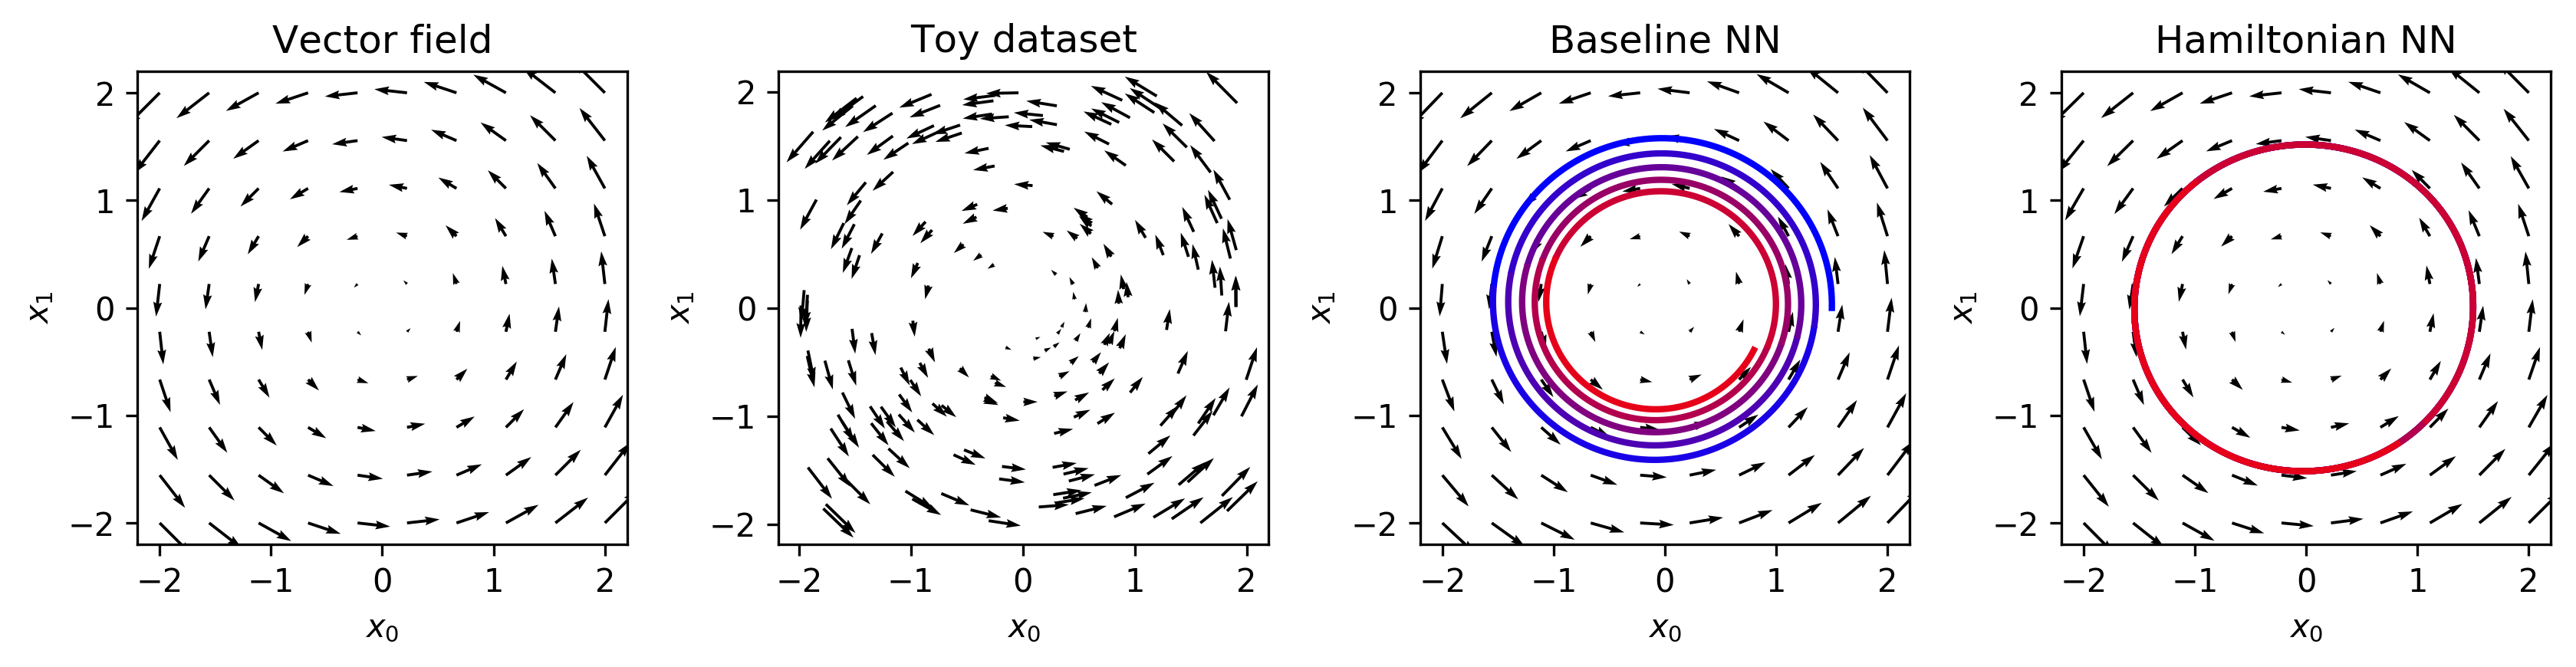

In [20]:
###### PLOT ######
fig = plt.figure(figsize=(11.3, 3), facecolor='white', dpi=DPI)

# plot vector field
ax = fig.add_subplot(1, 4, 1, frameon=True)
ax.quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)  
ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Vector field")

# plot dataset
ax = fig.add_subplot(1, 4, 2, frameon=True)
ax.quiver(data['x'][:,0], data['x'][:,1], data['dx'][:,0], data['dx'][:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)  
ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Toy dataset")

# plot baseline
ax = fig.add_subplot(1, 4, 3, frameon=True)
ax.quiver(field['x'][:,0], field['x'][:,1], base_field[:,0], base_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)

for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Baseline NN")

# plot HNN
ax = fig.add_subplot(1, 4, 4, frameon=True)
ax.quiver(field['x'][:,0], field['x'][:,1], hnn_field[:,0], hnn_field[:,1],
        cmap='gray_r', scale=ARROW_SCALE, width=ARROW_WIDTH)

for i, l in enumerate(np.split(hnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    ax.plot(l[:,0],l[:,1],color=color, linewidth=LINE_WIDTH)

ax.set_xlabel("$x_0$") ; ax.set_ylabel("$x_1$")
ax.set_title("Hamiltonian NN")

plt.tight_layout() ; plt.show()
fig.savefig('{}/toy{}.{}'.format(args.fig_dir, RK4, FORMAT))

## Quantitative analysis
* Choose trajectories from the test set
* Measure vector field loss at each point
* Integrate along trajectory and measure mean loss between points

In [21]:
def integrate_models(x0=np.asarray([1, 0]), t_span=[0,5], t_evals=100):
    # integrate along ground truth vector field
    kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], t_evals), 'rtol': 1e-12}
    true_path = solve_ivp(fun=circular_vector_field, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    true_dx = circular_vector_field(t=None, x=true_x)

    # integrate along baseline vector field
    base_path = integrate_model(base_model, t_span, x0, **kwargs)
    base_x = base_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    base_dx = base_model.time_derivative(_tmp).data.numpy()

    # integrate along HNN vector field
    hnn_path = integrate_model(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_path['y'].T
    _tmp = torch.tensor( true_x, requires_grad=True, dtype=torch.float32)
    hnn_dx = hnn_model.time_derivative(_tmp).data.numpy()
    
    return true_x, true_dx, base_x, base_dx, hnn_x, hnn_dx

def vector_field_loss(x, dx_hat):
    dx = circular_vector_field(t=None, x=x)
    return np.mean((dx - dx_hat)**2)

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

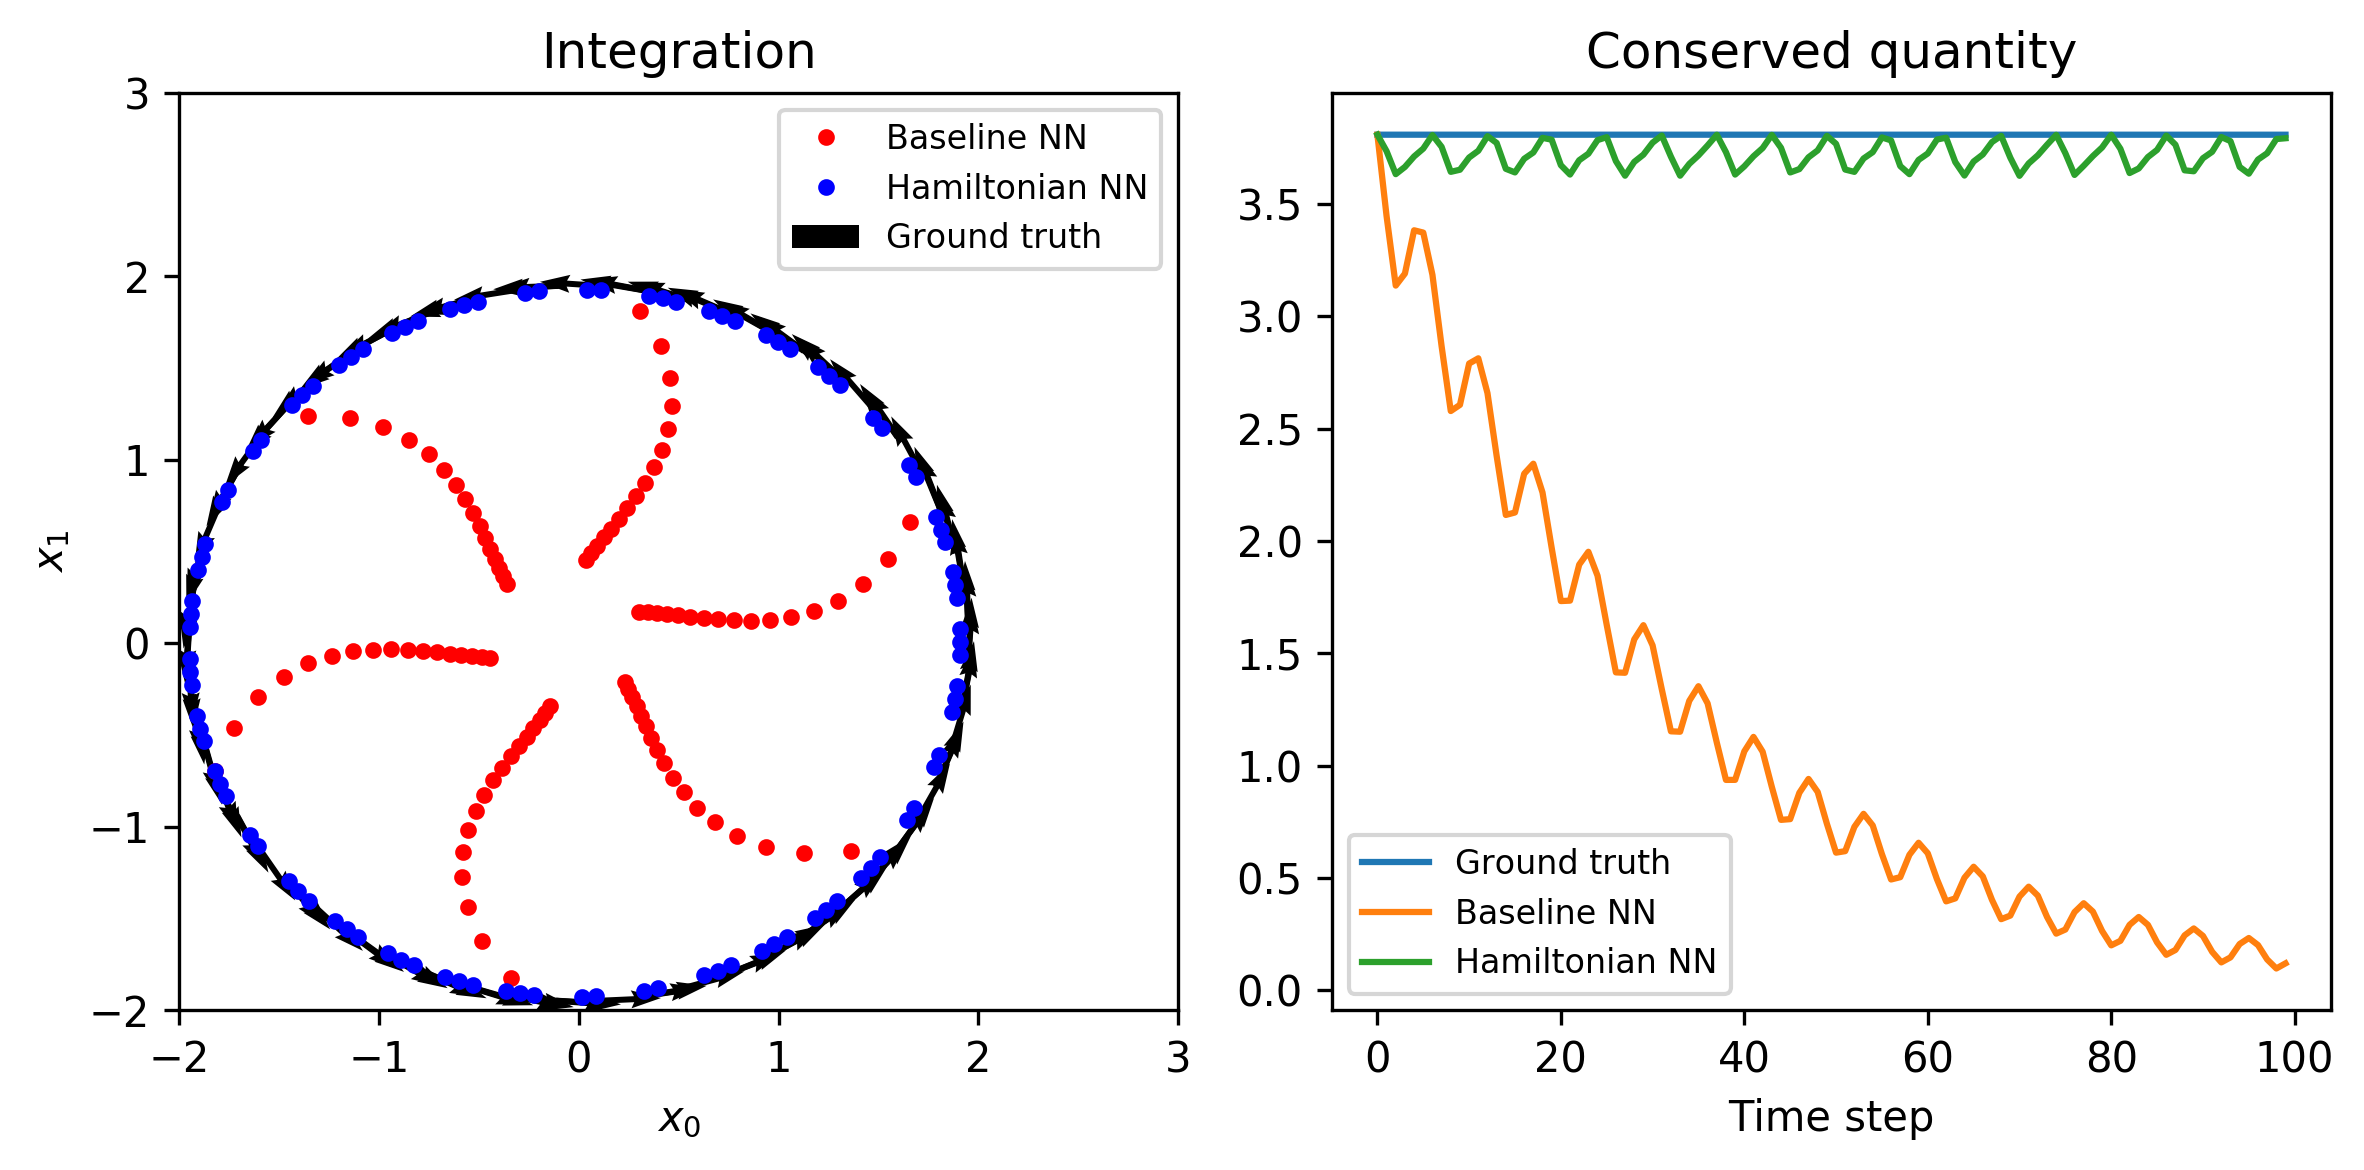

In [28]:
x0 = np.random.rand(2)*2.6 - 1.8 # randomly sample a starting px: \in(-1.5,1.5) and abs(px) > 0.2
x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
# x0 = np.asarray([2, 0])

# integration
vals = integrate_models(x0=x0, t_span=[0,100], t_evals=100)
[true_x, true_dx, base_x, base_dx, hnn_x, hnn_dx] = vals

# plotting
fig = plt.figure(figsize=[8,4], dpi=DPI)
plt.subplot(1,2,1)
plt.title("Integration") ; plt.xlabel('$x_0$') ; plt.ylabel('$x_1$')
plt.quiver(true_x[:,0], true_x[:,1], true_dx[:,0], true_dx[:,1],
           color='black', scale=ARROW_SCALE, width=ARROW_WIDTH, label='Ground truth')
plt.plot(base_x[:,0], base_x[:,1], 'r.', label='Baseline NN')
plt.plot(hnn_x[:,0], hnn_x[:,1], 'b.', label='Hamiltonian NN')
plt.xlim(-2,3) ; plt.ylim(-2,3)
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Conserved quantity')
plt.xlabel('Time step')
plt.plot((true_x**2).sum(1), label='Ground truth')
plt.plot((base_x**2).sum(1), label='Baseline NN')
plt.plot((hnn_x**2).sum(1), label='Hamiltonian NN')
plt.legend(fontsize=8)

plt.tight_layout() ; plt.show()
fig.savefig('{}/toy-integration{}.{}'.format(args.fig_dir, RK4, FORMAT))

In [24]:
splits = 15
samples = 15
losses = {'base_test' : [], 'hnn_test' : [], 'base_energy' : [], 'hnn_energy' : []}

_tmp = [] # for computing batched means
for i in range(splits*samples):
    x0 = np.random.rand(2)*2.6 - 1.8 # randomly sample a starting px: \in(-2,2) and abs(px) > 0.2
    x0 += 0.2 * np.sign(x0) * np.ones_like(x0)
    vals = integrate_models(x0=x0, t_span=[0,100], t_evals=20)
    [true_x, true_dx, base_x, base_dx, hnn_x, hnn_dx] = vals
    
    losses['base_test'] += [ vector_field_loss(base_x, base_dx) ]
    losses['hnn_test'] += [ vector_field_loss(hnn_x, hnn_dx) ]
    losses['base_energy'] += [ energy_loss(true_x, base_x) ]
    losses['hnn_energy'] += [ energy_loss(true_x, hnn_x) ]
    print('{:.2f}% done'.format(100*float(i)/(splits*samples)), end='\r')

In [ ]:
losses = {k: np.array(v) for k,v in losses.items()}
bootstrap_std = lambda x, splits=5: np.std([np.mean(x_i) for x_i in np.split(x, splits)])

print("Baseline NN test loss: {:.4e} +/- {:.2e}\nHamiltonian NN test loss: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_test']), bootstrap_std(losses['base_test'], splits),
          np.mean(losses['hnn_test']), bootstrap_std(losses['hnn_test'], splits))
     )

print("\nBaseline NN energy MSE: {:.4e} +/- {:.2e}\nHamiltonian NN energy MSE: {:.4e} +/- {:.2e}"
      .format(
          np.mean(losses['base_energy']), bootstrap_std(losses['base_energy'], splits),
          np.mean(losses['hnn_energy']), bootstrap_std(losses['hnn_energy'], splits))
     )